# Shift identification pipeline - dummy data example

This is just a simple example on dummy data on how to use the shift identification function. 

In [8]:
import sys
sys.path.append("/Users/melanie/Source/shift_identification/")
import numpy as np
from shift_identification_detection.shift_identification import run_shift_identification
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
import torch

np.random.seed(3)

## Prevalence shift identification example

### Load dummy data

Text(0.5, 1.0, 'Test set with prevalence shift (0.1 positive)')

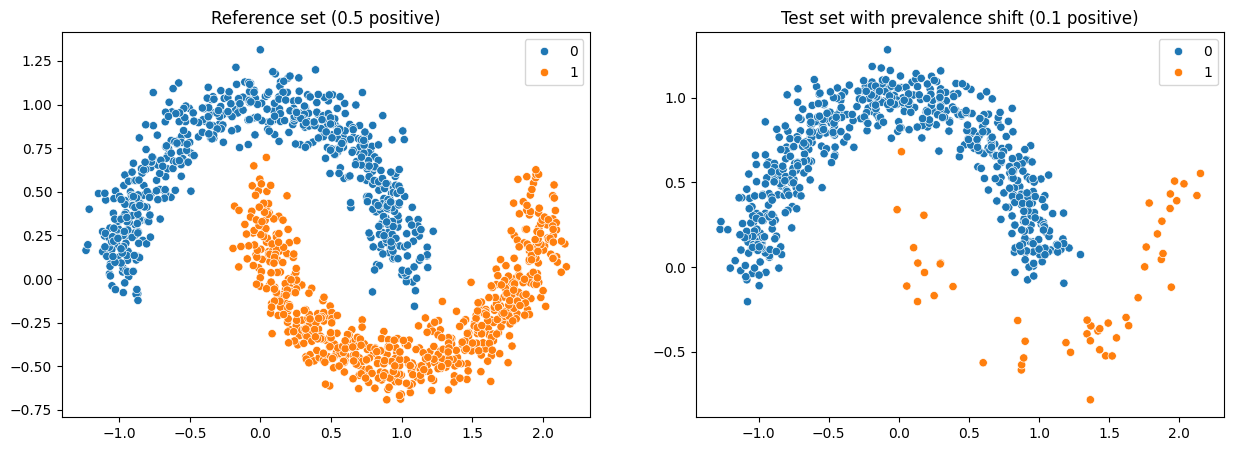

In [9]:
X, y = make_moons(n_samples=5000, shuffle=True, noise=0.1, random_state=None)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

# Create a prevalence shifted test set:
test_idx_shifted = np.concatenate([np.random.choice(np.where(y_test == 1)[0], 50, replace=False), np.random.choice(np.where(y_test == 0)[0], 600, replace=False)])
X_test_shifted, y_test_shifted = X_test[test_idx_shifted], y_test[test_idx_shifted]
# Plot created sets
f, ax = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(x=X_val[:, 0], y=X_val[:, 1], hue=y_val, ax=ax[0])
ax[0].set_title(f'Reference set ({y_val.mean():.1f} positive)')
sns.scatterplot(x=X_test_shifted[:, 0], y=X_test_shifted[:, 1], hue=y_test_shifted, ax=ax[1])
ax[1].set_title(f'Test set with prevalence shift ({y_test_shifted.mean():.1f} positive)')

### Train task model and generate dummy features

In [10]:
# Train task model and get predicted probabilities
clf = MLPClassifier(hidden_layer_sizes=[16], max_iter=500)
clf.fit(X_train, y_train)
probas_val = clf.predict_proba(X_val)
probas_test_shift = clf.predict_proba(X_test_shifted)
probas_val[:, 1].mean(), probas_test_shift[:, 1].mean()

# Get features for MMD based test
# On high-dimensional images, these would be extracted by a self-supervised encoder SimCLR ResNet.
# For this dummy example we'll just create dummy features which are [x1, x2, x1, x2, x1, x2, ....] repeated to get a dummy input features of size [128].
dummy_val_feats = X_val.repeat(64, 1)
dummy_test_feats = X_test_shifted.repeat(64, 1)

/Users/melanie/miniconda3/envs/classification/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Format data for shift identification pipeline and run pipeline

In [11]:
task_model_output = {
    'val': {'y': torch.tensor(y_val), 'probas': torch.tensor(probas_val)},
    'test': {'probas': torch.tensor(probas_test_shift)}
}

feature_model_output = {
    'val': {'feats': torch.tensor(dummy_val_feats)},
    'test': {'feats': torch.tensor(dummy_test_feats)}
}

results = run_shift_identification(
    task_output=task_model_output,
    encoder_output=feature_model_output,
    val_idx=np.arange(X_val.shape[0]), # use the entire validation set as reference set
    idx_shifted=np.arange(X_test_shifted.shape[0]), # use the entire shifted test set as target set
    num_classes=2
)
results

Took 0.009343147277832031 for PCA
Took 16.190824031829834 for MMD
Took 0.00034689903259277344 for resampling


{'bbsd_is_significant': True,
 'mmd_pvalue': 0.001,
 'mmd_is_significant': True,
 'mmd_resample_is_significant': False,
 'bbsd_resampled_is_significant': False,
 'mmd_resampled_pvalue': 0.291,
 'duo_is_significant': True,
 'final_identified_shift': 'Prevalence shift'}

In [12]:
print(f'The identified shift is {results['final_identified_shift']}')

The identified shift is Prevalence shift


## Another example with covariate + prevalence shift

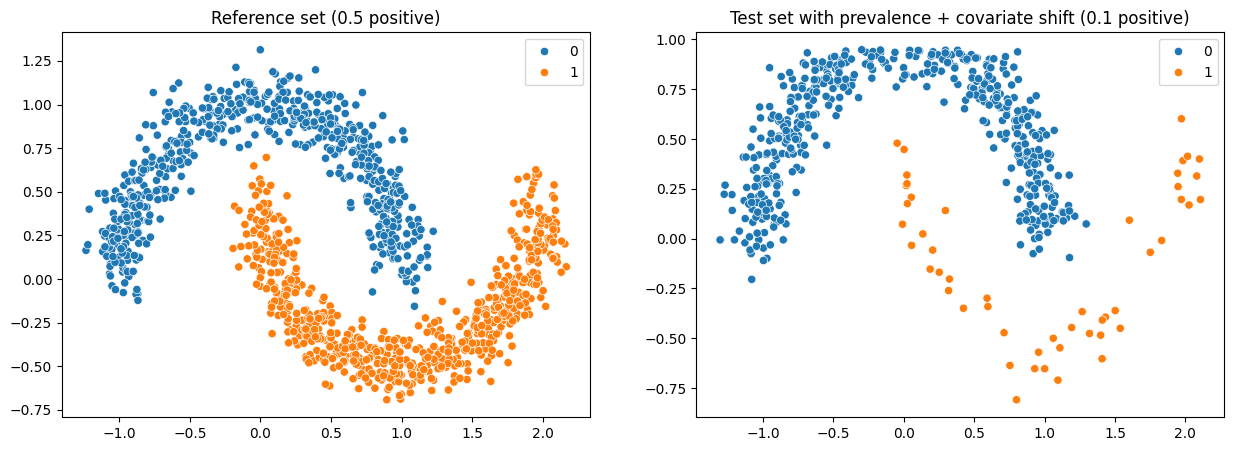

Took 0.011596202850341797 for PCA
Took 13.86392092704773 for MMD
Took 0.00029468536376953125 for resampling
The identified shift is Covariate + Prevalence


In [13]:
# Create a prevalence + covariate shifted test set:
test_idx_shifted = np.concatenate([np.random.choice(np.where(y_test == 1)[0], 50, replace=False), np.random.choice(np.where(y_test == 0)[0], 600, replace=False)])
X_test_shifted, y_test_shifted = X_test[test_idx_shifted], y_test[test_idx_shifted]
shifted_plus_idx = np.where(np.abs(X_test_shifted[:, 1]) < 0.95)[0]
X_test_shifted, y_test_shifted = X_test_shifted[shifted_plus_idx], y_test_shifted[shifted_plus_idx]

# Plot created sets
f, ax = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(x=X_val[:, 0], y=X_val[:, 1], hue=y_val, ax=ax[0])
ax[0].set_title(f'Reference set ({y_val.mean():.1f} positive)')
sns.scatterplot(x=X_test_shifted[:, 0], y=X_test_shifted[:, 1], hue=y_test_shifted, ax=ax[1])
ax[1].set_title(f'Test set with prevalence + covariate shift ({y_test_shifted.mean():.1f} positive)')
plt.show()

# Train task model and get predicted probabilities
clf = MLPClassifier(hidden_layer_sizes=[16], max_iter=500)
clf.fit(X_train, y_train)
probas_val = clf.predict_proba(X_val)
probas_test_shift = clf.predict_proba(X_test_shifted)
probas_val[:, 1].mean(), probas_test_shift[:, 1].mean()

# Get features for MMD based test
# On high-dimensional images, these would be extracted by a self-supervised encoder SimCLR ResNet.
# For this dummy example we'll just create dummy features which are [x1, x2, x1, x2, x1, x2, ....] repeated to get a dummy input features of size [128].
dummy_val_feats = X_val.repeat(64, 1)
dummy_test_feats = X_test_shifted.repeat(64, 1)


task_model_output = {
    'val': {'y': torch.tensor(y_val), 'probas': torch.tensor(probas_val)},
    'test': {'probas': torch.tensor(probas_test_shift)}
}

feature_model_output = {
    'val': {'feats': torch.tensor(dummy_val_feats)},
    'test': {'feats': torch.tensor(dummy_test_feats)}
}

results = run_shift_identification(
    task_output=task_model_output,
    encoder_output=feature_model_output,
    val_idx=np.arange(X_val.shape[0]), # use the entire validation set as reference set
    idx_shifted=np.arange(X_test_shifted.shape[0]), # use the entire shifted test set as target set
    num_classes=2
)
print(f'The identified shift is {results['final_identified_shift']}')


## Another example with covariate only

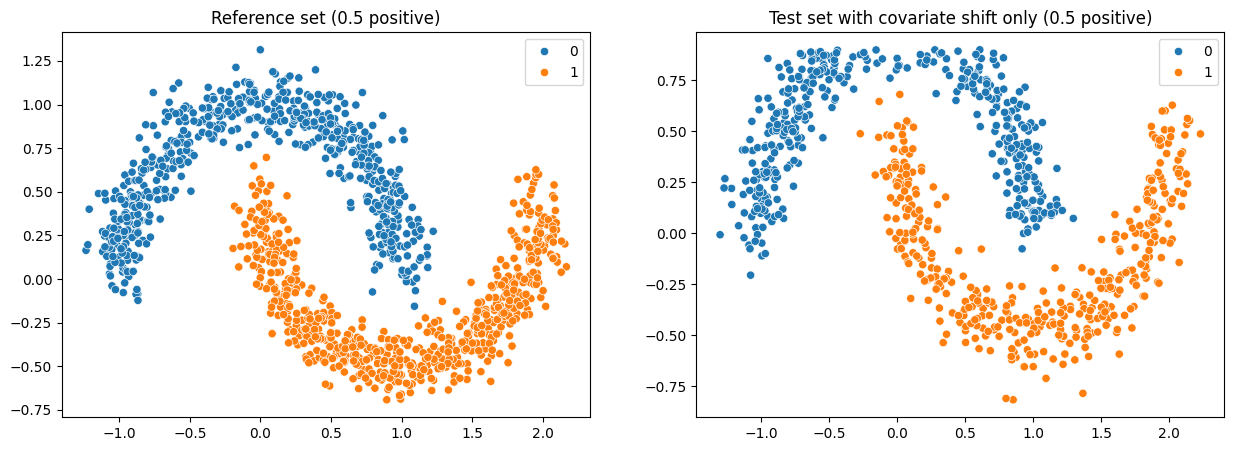

Took 0.015686988830566406 for PCA
Took 18.167101860046387 for MMD
Took 0.00026607513427734375 for resampling
The identified shift is Covariate only


In [14]:
# Create a covariate shifted test set:

shifted_plus_idx = np.where(np.abs(X_test[:, 1]) < 0.9)[0]
X_test_shifted, y_test_shifted = X_test[shifted_plus_idx], y_test[shifted_plus_idx]
test_idx_shifted = np.concatenate([np.random.choice(np.where(y_test_shifted == 1)[0], 400, replace=False), np.random.choice(np.where(y_test_shifted == 0)[0], 400, replace=False)])
X_test_shifted, y_test_shifted = X_test_shifted[test_idx_shifted], y_test_shifted[test_idx_shifted]


# Plot created sets
f, ax = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(x=X_val[:, 0], y=X_val[:, 1], hue=y_val, ax=ax[0])
ax[0].set_title(f'Reference set ({y_val.mean():.1f} positive)')
sns.scatterplot(x=X_test_shifted[:, 0], y=X_test_shifted[:, 1], hue=y_test_shifted, ax=ax[1])
ax[1].set_title(f'Test set with covariate shift only ({y_test_shifted.mean():.1f} positive)')
plt.show()
# Train task model and get predicted probabilities
clf = MLPClassifier(hidden_layer_sizes=[16], max_iter=500)
clf.fit(X_train, y_train)
probas_val = clf.predict_proba(X_val)
probas_test_shift = clf.predict_proba(X_test_shifted)

# Get features for MMD based test
# On high-dimensional images, these would be extracted by a self-supervised encoder SimCLR ResNet.
# For this dummy example we'll just create dummy features which are [x1, x2, x1, x2, x1, x2, ....] repeated to get a dummy input features of size [128].
dummy_val_feats = X_val.repeat(64, 1)
dummy_test_feats = X_test_shifted.repeat(64, 1)


task_model_output = {
    'val': {'y': torch.tensor(y_val), 'probas': torch.tensor(probas_val)},
    'test': {'probas': torch.tensor(probas_test_shift)}
}

feature_model_output = {
    'val': {'feats': torch.tensor(dummy_val_feats)},
    'test': {'feats': torch.tensor(dummy_test_feats)}
}

results = run_shift_identification(
    task_output=task_model_output,
    encoder_output=feature_model_output,
    val_idx=np.arange(X_val.shape[0]), # use the entire validation set as reference set
    idx_shifted=np.arange(X_test_shifted.shape[0]), # use the entire shifted test set as target set
    num_classes=2
)
print(f'The identified shift is {results['final_identified_shift']}')